In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np

from sympy import *
from sympy.parsing.sympy_parser import parse_expr
from sympy.abc import x

import ipywidgets as widgets

In [2]:
# Define some helpful functions

def truncated_taylor_series(func, arg, point, n):
    """
    returns a truncated taylor series as a numpy function
    """
    return lambdify(x, series(func, arg, point, n).removeO(), 'numpy')

def plot_trunc_taylor(f, x, x0, n, xs, **kwargs):
    """
    plots the truncated taylor series of f as a function of x for a point x0, where n denotes the 
    degree of the first truncated monomial. xs is a numpy array of x values, for which the plot will
    be created. Additional keyword arguments can be forwarded to the matplotlib plot command.
    """
    if n==1:
        # Since the truncated taylor series is a constant, we have to multiply by an array of ones that
        # as the same size as xs
        ys = truncated_taylor_series(f, x, x0, 1)(xs)*np.ones(np.shape(xs))
    else:
        ys = truncated_taylor_series(f, x, x0, n)(xs)
        
    # plot the results and return the plot handle
    return plt.gca().plot(xs, ys, **kwargs)

# we need functions to interactively update the hlines and vlines
# https://stackoverflow.com/questions/29331401/updating-pyplot-vlines-in-interactive-plot
def update_vlines(*, h, x, ymin=None, ymax=None):
    seg_old = h.get_segments()
    if ymin is None:
        ymin = seg_old[0][0, 1]
    if ymax is None:
        ymax = seg_old[0][1, 1]

    seg_new = [np.array([[x, ymin],
                        [x, ymax]]),]

    h.set_segments(seg_new)
    
def update_hlines(*, h, y, xmin=None, xmax=None):
    seg_old = h.get_segments()
    if xmin is None:
        xmin = seg_old[0][0, 0]
    if xmax is None:
        xmax = seg_old[0][1, 0]

    seg_new = [np.array([[xmin, y],
                         [xmax, y]]),]

    h.set_segments(seg_new)

<IPython.core.display.Javascript object>


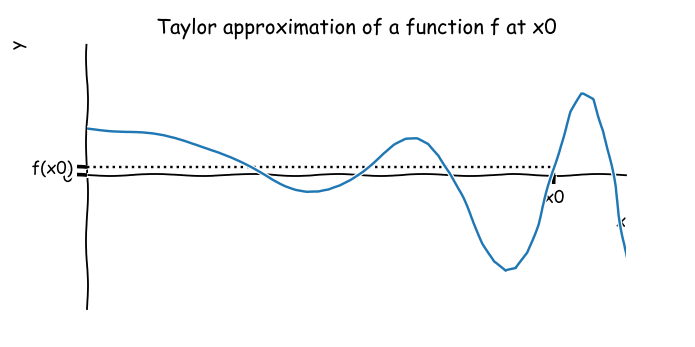

In [5]:
f           = 25 + exp(x)*sin(x**2) - 10*x
x0_init     = 2.3
degree_init = 0

xmin_init = 1
xmax_init = 4
ymin_init = -50
ymax_init = 50
res_init  = 50

##################################
# Create the interactive widgets #
##################################

visible = widgets.ToggleButton(
    value=False,
    description='Toggle visibility of Taylor polynomial',
    disabled=False,
    tooltip='Toggle visibility of Taylor polynomial',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)
x0 = widgets.FloatSlider(
    value=x0_init,
    min=xmin_init,
    max=xmax_init,
    step=0.1,
    description='x0',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
degree = widgets.IntSlider(
    value=degree_init,
    min=0,
    max=10,
    description='degree',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True
)
func = widgets.Text(
    description="Function", 
    value=str(f))
xmin = widgets.FloatText(
    value=xmin_init,
    description='xmin',
    disabled=False
)
xmax = widgets.FloatText(
    value=xmax_init,
    description='xmax',
    disabled=False
)
ymin = widgets.FloatText(
    value=ymin_init,
    description='ymin',
    disabled=False
)
ymax = widgets.FloatText(
    value=ymax_init,
    description='ymax',
    disabled=False
)

# x0 slider limits depend on xmin and xmax
def update_x_range(*args):
    x0.min = xmin.value
    x0.max = xmax.value
xmin.observe(update_x_range, 'value')
xmax.observe(update_x_range, 'value')

# organize all widgets into two tabs
tab = widgets.Tab()
tab.children = [
    widgets.VBox([
        visible, 
        x0, 
        degree
    ]),
    widgets.VBox([
        func,
        widgets.Label("Display options"),
        widgets.HBox([
          xmin,
          xmax
        ]),
        widgets.HBox([
          ymin,
          ymax
        ])
    ])
]
tab.set_title(0, f"Taylor polynomial")
tab.set_title(1, f"Advanced")

#############################################
# Define the function that updates the plot #
#############################################

def update_plot(visible=False, 
                function=f, 
                x0=x0_init, 
                degree=degree_init, 
                xmin=xmin_init,
                xmax=xmax_init,
                ymin=ymin_init,
                ymax=ymax_init,
                xresolution=res_init,
                handles={}):
    """
    Updates the plot.
    """
    
    # parse symbolic representation of function
    f = parse_expr(function)
    
    # evaluate function at x0
    fx0 = f.subs(x, x0)
    
    # update the x values for plotting
    xs = np.linspace(xmin, xmax, xresolution)
    
    if not fs:
        #######################
        # Initialize the plot #
        #######################
        ax = plt.gca()

        
        # plot f and append the plot handle
        fs["func"] = ax.plot(xs, lambdify(x, f, 'numpy')(xs), label="f")[0]

        ###############################################
        # Plot the truncated taylor series at x0_init #
        ###############################################

        # plot the constant Taylor polynomial
        fs["taylor"] = plot_trunc_taylor(f, 
                                         x, 
                                         x0, 
                                         degree + 1, 
                                         xs, 
                                         color='g',
                                         label='Taylor polynomial of degree {} at x0'.format(degree_init))[0]

        # Set visiblity to zero. This will be changed in the ipywidgets later on.
        fs["taylor"].set_visible(False)

        ###############################
        # Beautify the plot some more #
        ###############################

        plt.title('Taylor approximation of a function f at x0')
        plt.xlabel('x',horizontalalignment='right', x=1)
        plt.ylabel('y',horizontalalignment='right', x=0, y=1)

        # set the z order of the axes spines
        for k, spine in ax.spines.items(): 
            spine.set_zorder(0)

        # set the axes locations and style
        ax.spines['top'].set_color('none')
        ax.spines['bottom'].set_position(('data', 0))
        ax.spines['right'].set_color('none')

        # set x and y ticks, labels and limits respectively
        plt.xticks(ticks=[x0_init], labels=["x0",])
        plt.yticks(ticks=[0, fx0], labels=["0", "f(x0)",])
        plt.ylim([-50,50])

        # draw lines for (x0, f(x0))
        fs["vline"] = plt.vlines(x=x0_init, ymin=float(min(0, fx0)), ymax=float(max(0, fx0)), colors='black', ls=':', lw=2)
        fs["hline"] = plt.hlines(y=float(fx0), xmin=xmin_init, xmax=x0_init, colors='black', ls=':', lw=2)

        
    else:
        ###################
        # Update the plot #
        ###################
    
        fs["func"].set_xdata(xs)
        fs["func"].set_ydata(lambdify(x, f, 'numpy')(xs))
        fs["taylor"].set_xdata(xs)
        fs["taylor"].set_ydata(truncated_taylor_series(f, x, x0, degree+1)(xs))

        # update the visibility of the Taylor expansion
        fs["taylor"].set_visible(visible)

        # update the coordinate cross around (x0, f(x0))
        plt.xticks(ticks=[x0], labels=["x0",])
        plt.yticks(ticks=[0, fx0], labels=["0", "f(x0)",])

        update_vlines(h=fs["vline"], x=x0, ymin=float(min(0, fx0)), ymax=float(max(0, fx0)))
        update_hlines(h=fs["hline"], y=float(fx0), xmin=xmin, xmax=x0)

        # update axes limits
        plt.xlim([xmin, xmax])
        plt.ylim([ymin, ymax])
        
    
    plt.show(plt.gcf())


# initialize the figure and initialize an empty dict of plot handles
plt.xkcd() # <-- beautiful xkcd style
fig = plt.figure(figsize=(8,4))
fs = {}

# connect function arguments of update_plot to widgets
out = widgets.interactive_output(update_plot, {'visible': visible, 
                                               'function': func, 
                                               'x0': x0, 
                                               'degree': degree,
                                               'xmin': xmin,
                                               'xmax': xmax,
                                               'ymin': ymin,
                                               'ymax': ymax,
                                               'xresolution': widgets.fixed(res_init),
                                               'handles': widgets.fixed(fs)
                                              })

tab